# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$. 

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  > 
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)

In [26]:
def random_tour(n):
    """Create a random tour"""
    
    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[2, 7, 1, 5, 6, 8, 9, 3, 4, 0]

In [27]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a 
    pairwise Euclidean distance matrix.
    """
    
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    
    dist = squareform(pdist(pos))
    
    return({"pos": pos, "dist": dist})
    
tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [28]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""
    
    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()
    
    tl = 0
    dist = tsp["dist"]
    
    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]
    
    tl += dist[tour[-1], tour[0]]
    
    return(tl)
        
tour = random_tour(10)
tour_length(tsp, tour)

np.float64(5.243340293717205)

In [29]:
def show_tsp(tsp, tour=None):  
    """display the traveling salesman problem and a tour."""
    
    pos = tsp["pos"]
    plt.scatter(pos["x"], pos["y"])
    
    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): 
            tour = tour.tolist()
        
        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")
        
        pos_ = pos.reindex(tour)
        pos_ = pd.concat([pos_, pos_.head(1)])   # ✅ dùng concat thay vì append
        plt.plot(pos_["x"], pos_["y"])
    
    plt.show()


## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [30]:
# %load_ext rpy2.ipython

# %R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
# %R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

# d = tsp["dist"]

Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

Tour length: 5.36


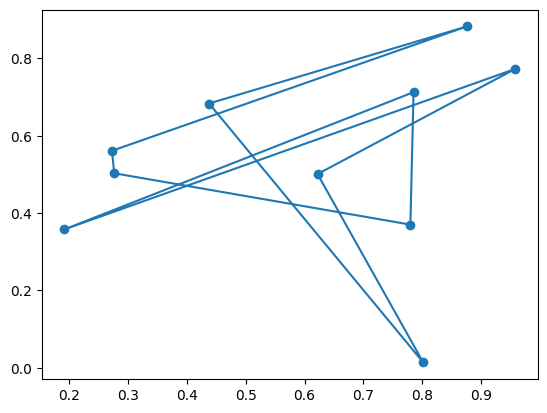

In [31]:
# %%R -i d -o tour

# library("TSP")

# tsp <- TSP(d)
# print(tsp)

# tour <- solve_TSP(tsp, rep = 100)
# print(tour)

# # R starts index with 1, but Python starts at 0
# tour <- tour - 1L
tour = random_tour(len(tsp["pos"]))
show_tsp(tsp, tour)

Tour length: 5.36


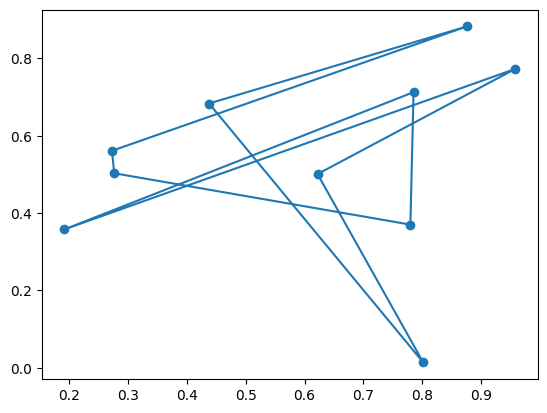

In [32]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [33]:
# %%R -i d

# library("microbenchmark")

# microbenchmark(tsp <- TSP(d))

## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

Start length: 5.0614
Best length:  2.8056, steps: 7
Tour length: 2.81


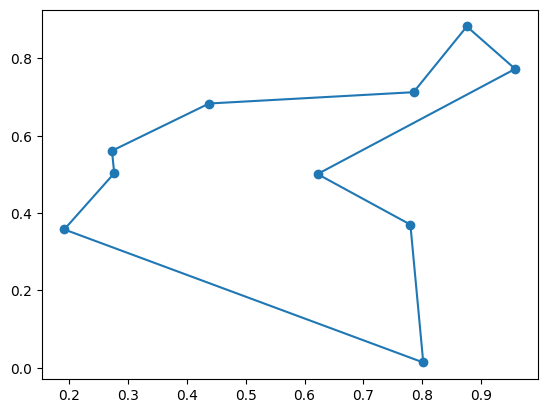

In [34]:
# Code goes here
def steepest_hill_climb(tsp, start_tour):
    cur = start_tour[:] if isinstance(start_tour, list) else start_tour.tolist()
    cur_len = tour_length(tsp, cur)
    steps = 0
    improved = True
    n = len(cur)

    while improved:
        improved = False
        best_neighbor = None
        best_len = cur_len

        for i in range(n - 1):
            for j in range(i + 1, n):
                nb = cur[:]
                nb[i], nb[j] = nb[j], nb[i]
                nb_len = tour_length(tsp, nb)
                if nb_len < best_len - 1e-12:
                    best_len = nb_len
                    best_neighbor = nb

        if best_neighbor is not None:
            cur = best_neighbor
            cur_len = best_len
            steps += 1
            improved = True

    return cur, cur_len, steps

start = random_tour(len(tsp["pos"]))
best_tour, best_len, steps = steepest_hill_climb(tsp, start)
print(f"Start length: {tour_length(tsp, start):.4f}")
print(f"Best length:  {best_len:.4f}, steps: {steps}")
show_tsp(tsp, best_tour)

## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

RR best length: 2.7636, steps of last climb: 6
Tour length: 2.76


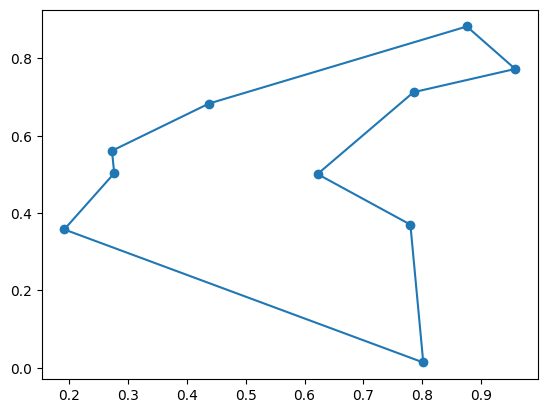

In [ ]:
# Code goes here
def steepest_hill_climb_random_restarts(tsp, restarts=100):
    best_overall = None
    best_len = float("inf")
    best_steps = 0
    n = len(tsp["pos"])

    for r in range(restarts):
        start = random_tour(n)
        tour, tl, steps = steepest_hill_climb(tsp, start)
        if tl < best_len:
            best_overall, best_len, best_steps = tour, tl, steps

    return best_overall, best_len, best_steps

rr_tour, rr_len, rr_steps = steepest_hill_climb_random_restarts(tsp, restarts=100)
print(f"RR best length: {rr_len:.4f}, steps of last climb: {rr_steps}")
show_tsp(tsp, rr_tour)


## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

Stochastic best length: 12.7929, steps: 350
Tour length: 12.79


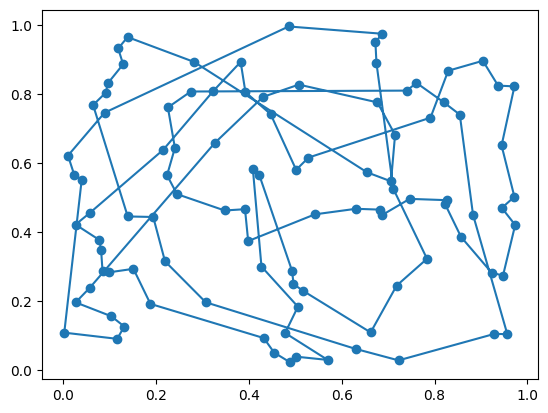

In [14]:
# Code goes here
def stochastic_hill_climb(tsp, start_tour, max_iters=10000):
    cur = start_tour[:] if isinstance(start_tour, list) else start_tour.tolist()
    cur_len = tour_length(tsp, cur)
    steps = 0
    n = len(cur)

    while steps < max_iters:
        better = []
        for i in range(n - 1):
            for j in range(i + 1, n):
                nb = cur[:]
                nb[i], nb[j] = nb[j], nb[i]
                nb_len = tour_length(tsp, nb)
                if nb_len < cur_len - 1e-12:
                    better.append((nb, nb_len))

        if not better:
            break

        nb, nb_len = random.choice(better)
        cur, cur_len = nb, nb_len
        steps += 1

    return cur, cur_len, steps

start = random_tour(len(tsp["pos"]))
st_tour, st_len, st_steps = stochastic_hill_climb(tsp, start)
print(f"Stochastic best length: {st_len:.4f}, steps: {st_steps}")
show_tsp(tsp, st_tour)


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

In [15]:
def first_choice_hill_climbing(tsp, max_iter=1000):
    tour = random_tour(len(tsp['dist']))
    current_length = tour_length(tsp, tour)
    for _ in range(max_iter):
        improved = False
        neighbors = []
        for i in range(len(tour)):
            for j in range(i+1, len(tour)):
                neighbor = tour[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        random.shuffle(neighbors)
        for neighbor in neighbors:
            neighbor_length = tour_length(tsp, neighbor)
            if neighbor_length < current_length:
                tour = neighbor
                current_length = neighbor_length
                improved = True
                break
        if not improved:
            break
    return tour, current_length

## Simulated Annealing [2 Points]

In [16]:
def simulated_annealing(tsp, T0=1000, alpha=0.99, T_min=1e-5, max_steps=10000):
    tour = random_tour(len(tsp['dist']))
    current_length = tour_length(tsp, tour)
    T = T0
    for t in range(max_steps):
        if T < T_min:
            break
        i, j = random.sample(range(len(tour)), 2)
        neighbor = tour[:]
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbor_length = tour_length(tsp, neighbor)
        delta = neighbor_length - current_length
        if delta < 0 or random.random() < math.exp(-delta / T):
            tour = neighbor
            current_length = neighbor_length
        T *= alpha
    return tour, current_length

## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [17]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 1.0006427764892578 milliseconds


In [19]:
import time
sizes = [10, 20, 30,40,60,60,70,80,90,100]
algorithms = {
    'First-Choice HC': first_choice_hill_climbing,
    'Simulated Annealing': simulated_annealing
}
results = {}
for n in sizes:
    tsp = random_tsp(n)
    results[n] = {}
    for name, func in algorithms.items():
        start = time.time()
        _, length = func(tsp)
        runtime = time.time() - start
        results[n][name] = {'runtime': runtime, 'length': length}
print(results)

{10: {'First-Choice HC': {'runtime': 0.0010030269622802734, 'length': np.float64(3.182708858047767)}, 'Simulated Annealing': {'runtime': 0.008995532989501953, 'length': np.float64(3.1827088580477674)}}, 20: {'First-Choice HC': {'runtime': 0.003999233245849609, 'length': np.float64(5.06225186116396)}, 'Simulated Annealing': {'runtime': 0.011000394821166992, 'length': np.float64(4.804362670751023)}}, 30: {'First-Choice HC': {'runtime': 0.020998716354370117, 'length': np.float64(5.236866703345944)}, 'Simulated Annealing': {'runtime': 0.013000011444091797, 'length': np.float64(5.7760925106371355)}}, 40: {'First-Choice HC': {'runtime': 0.09300112724304199, 'length': np.float64(8.025815310557979)}, 'Simulated Annealing': {'runtime': 0.01699995994567871, 'length': np.float64(8.146225194160815)}}, 60: {'First-Choice HC': {'runtime': 0.28304100036621094, 'length': np.float64(10.44355550583289)}, 'Simulated Annealing': {'runtime': 0.020006179809570312, 'length': np.float64(14.226503142957514)}},

## Bonus: Genetic Algorithm [+1 Point]

In [41]:
# Code goes here